<a href="https://colab.research.google.com/github/luisflorenz/jupyter_data/blob/main/deep_learning_project_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# deep-learning-project-from-scratch



For this project you will choose a data set of your choice and you will apply the concepts learned in this course to train end-to-end deep learning models with PyTorch, experimenting with different hyperparameters and metrics.

 1- Find a dataset online (see the "Where to Find Datasets" section below)

 2- Understand and describe the modeling objective clearly
What type of data is it? (images, text, audio, etc.)
What type of problem is it? (regression, classification, generative modeling, etc.)

 3- Clean the data if required and perform exploratory analysis (plot graphs, ask questions)

 4- Modeling
Define a model (network architecture)
Pick some hyperparameters
Train the model
Make predictions on samples
Evaluate on the test dataset
Save the model weights
Record the metrics
Try different hyperparameters & regularization

 5- Conclusions - summarize your learning & identify opportunities for future work

 6- Publish and submit your Jupyter notebook

##  1- Find a Datasetet

In [1]:
! pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od

In [3]:
dataset_url = 'https://www.kaggle.com/datasets/alxmamaev/flowers-recognition'

In [4]:
od.download(dataset_url)

100%|██████████| 225M/225M [00:06<00:00, 36.4MB/s]


In [5]:
data_dir = './flowers-recognition/flowers'

In [6]:
import os

In [7]:
os.listdir(data_dir)

['sunflower', 'rose', 'dandelion', 'tulip', 'daisy']

In [8]:
for cls in os.listdir(data_dir):
  print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

sunflower : 733
rose : 784
dandelion : 1052
tulip : 984
daisy : 764


## Import the dataset into Pyytorch

In [35]:
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [10]:
dataset = ImageFolder(data_dir)

In [11]:
len(dataset)

4317

In [12]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

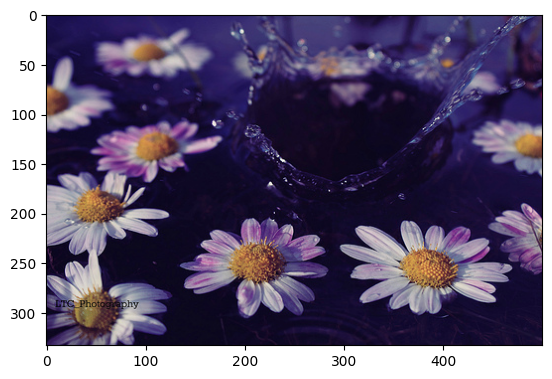

In [13]:
img, label = dataset[3]
plt.imshow(img)

In [14]:
dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64), tt.RandomCrop(64), tt.ToTensor()]))

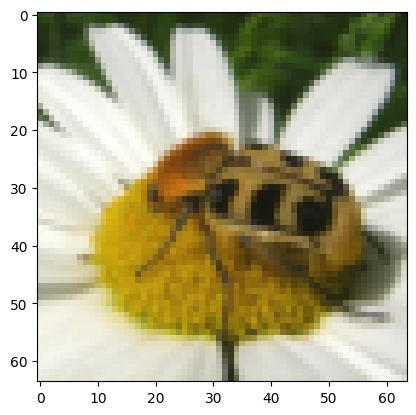

In [15]:
img, label = dataset[120]
plt.imshow(img.permute((1,2,0)))

In [16]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = int(len(dataset) - val_size)

train_size, val_size

(3886, 431)

In [17]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(3886, 431)

In [ ]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)
batch_size = 128
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=4, pin_memory=True)


In [18]:
batch_size = 128

In [19]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [20]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

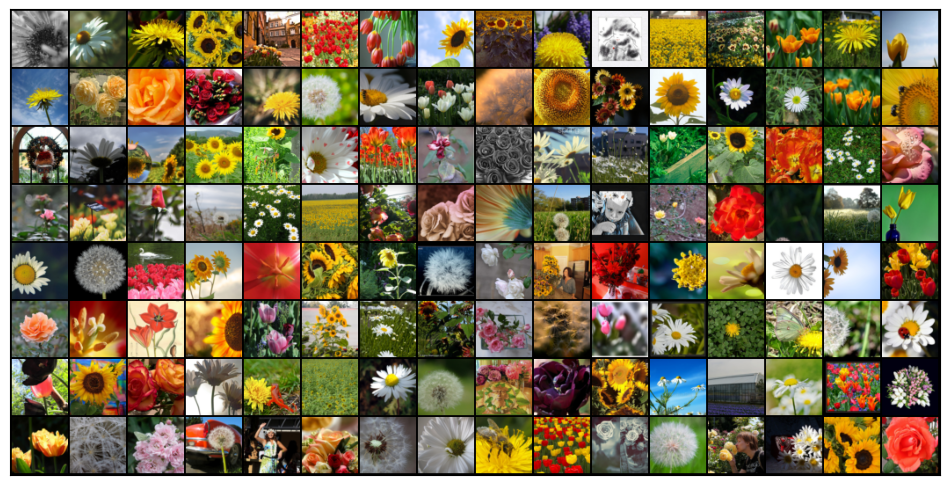

In [21]:
show_batch(train_dl)

In [22]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [23]:
device = get_default_device()
device

device(type='cuda')

In [24]:
img, label = dataset[3]

In [25]:
img

tensor([[[0.1020, 0.0980, 0.0980,  ..., 0.1059, 0.1059, 0.1059],
         [0.1059, 0.1020, 0.1020,  ..., 0.1255, 0.1294, 0.1137],
         [0.1020, 0.1020, 0.1059,  ..., 0.1725, 0.1686, 0.1647],
         ...,
         [0.0745, 0.0667, 0.0941,  ..., 0.0784, 0.0824, 0.0784],
         [0.0706, 0.1373, 0.2196,  ..., 0.0745, 0.1020, 0.0980],
         [0.1647, 0.2353, 0.2980,  ..., 0.0902, 0.0863, 0.0784]],

        [[0.0627, 0.0627, 0.0588,  ..., 0.0588, 0.0627, 0.0588],
         [0.0667, 0.0627, 0.0627,  ..., 0.0745, 0.0784, 0.0667],
         [0.0667, 0.0667, 0.0706,  ..., 0.1059, 0.1059, 0.1059],
         ...,
         [0.0431, 0.0392, 0.0510,  ..., 0.0471, 0.0471, 0.0431],
         [0.0392, 0.0784, 0.1412,  ..., 0.0392, 0.0549, 0.0549],
         [0.0941, 0.1490, 0.2235,  ..., 0.0471, 0.0431, 0.0431]],

        [[0.3098, 0.3098, 0.3059,  ..., 0.2078, 0.2078, 0.2039],
         [0.3020, 0.3020, 0.3020,  ..., 0.2549, 0.2549, 0.2314],
         [0.2902, 0.2980, 0.3059,  ..., 0.3373, 0.3294, 0.

In [26]:
img.shape

torch.Size([3, 64, 64])

In [27]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model and Training Utilities

In [28]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [29]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        #input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32

        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [30]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [31]:
model.conv1[0].weight

Parameter containing:
tensor([[[[ 1.0274e-01,  8.0867e-02, -1.8569e-01],
          [-1.5437e-01,  6.9452e-02, -1.7231e-01],
          [-4.9829e-02, -1.8501e-01,  6.6110e-02]],

         [[-1.4463e-01,  5.3515e-02, -1.1796e-01],
          [ 4.8496e-02, -1.7290e-01,  1.6118e-01],
          [ 1.6784e-01,  1.6236e-01,  1.6706e-01]],

         [[-1.7852e-01, -1.4073e-01,  3.8609e-03],
          [-1.7259e-01,  1.1100e-02, -9.1625e-02],
          [ 1.9136e-01,  3.0378e-03,  1.4511e-01]]],


        [[[ 9.4552e-02, -1.8088e-01, -2.8473e-02],
          [ 9.4231e-02, -1.0024e-01,  3.0517e-02],
          [-1.3003e-01,  1.3549e-02, -1.5673e-01]],

         [[ 1.1711e-01, -1.7069e-02, -1.2156e-02],
          [ 1.3537e-01, -4.7456e-03, -1.1695e-01],
          [-1.7066e-01,  8.7030e-02, -1.7759e-01]],

         [[-1.7340e-01, -1.4693e-01,  1.2246e-01],
          [-1.7269e-01,  5.6170e-02, -1.7980e-01],
          [ 1.0749e-01, -1.4194e-01, -1.3490e-01]]],


        [[[-1.0006e-01, -1.7431e-01, -1.3057

In [32]:
model.conv1[0].weight.device

device(type='cuda', index=0)

Pass one batch of input tensor through to the model.

In [33]:
for batch in train_dl:
  images, label = batch
  print('images.shape', images.shape)
  print('images.device',images.device)
  preds = model(images)
  print('preds.shape',preds.shape)
  break

images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 5])


In [34]:
print(preds)

tensor([[-3.4209,  4.1816, -1.3271, -1.1595,  3.2289],
        [-1.4593,  7.1271, -2.2879, -1.0176,  2.5782],
        [-3.3187,  3.2696, -1.8244, -4.0437,  1.5923],
        [-4.3817,  7.4916, -1.9661, -4.0161,  0.7172],
        [-4.5302,  6.6587, -3.2877, -6.0500, -0.1928],
        [-2.2223,  4.3598,  0.2152, -4.4169,  1.6974],
        [-1.8140,  5.3509, -3.3196, -2.3531,  3.7599],
        [-2.9017,  5.6026, -3.3101, -2.5641,  3.1779],
        [ 0.3556,  4.7670, -1.3823, -2.9912,  1.4665],
        [-1.6575,  4.4320, -0.7337, -2.8031,  0.6705],
        [-2.7714,  7.8435, -4.2650, -3.9179,  0.8009],
        [-3.4560,  2.2885, -1.0621, -2.0188,  1.4743],
        [-0.9596,  2.8139, -0.4194, -1.8513,  0.7834],
        [-3.0221,  4.8617, -3.6451, -2.6593,  0.8372],
        [ 0.0466,  3.3781, -3.3882, -1.3817,  3.3699],
        [-2.2356,  6.7561, -2.9037, -3.7935,  3.0342],
        [-3.4098,  7.2194, -1.9069, -5.0257,  2.7532],
        [-0.5061,  6.4252,  0.1113, -6.0079,  0.6107],
        [-

## Training the model

In [79]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [80]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 0.6698529124259949, 'val_acc': 0.8583776950836182}]

In [81]:
epochs = 6
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [82]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], train_loss: 0.0224, val_loss: 0.6444, val_acc: 0.8754
Epoch [1], train_loss: 0.0900, val_loss: 1.1276, val_acc: 0.7559
Epoch [2], train_loss: 0.1582, val_loss: 0.6219, val_acc: 0.8417
Epoch [3], train_loss: 0.0696, val_loss: 0.6160, val_acc: 0.8612
Epoch [4], train_loss: 0.0319, val_loss: 0.5199, val_acc: 0.8710
Epoch [5], train_loss: 0.0195, val_loss: 0.5520, val_acc: 0.8724


In [109]:
epochs = 6
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-3
opt_func = torch.optim.Adam

In [110]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], train_loss: 0.0577, val_loss: 0.5516, val_acc: 0.8559
Epoch [1], train_loss: 0.1246, val_loss: 0.7419, val_acc: 0.8081
Epoch [2], train_loss: 0.1791, val_loss: 0.6656, val_acc: 0.8129
Epoch [3], train_loss: 0.1133, val_loss: 0.4647, val_acc: 0.8520
Epoch [4], train_loss: 0.0414, val_loss: 0.4234, val_acc: 0.8802
Epoch [5], train_loss: 0.0333, val_loss: 0.4806, val_acc: 0.8855


In [111]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

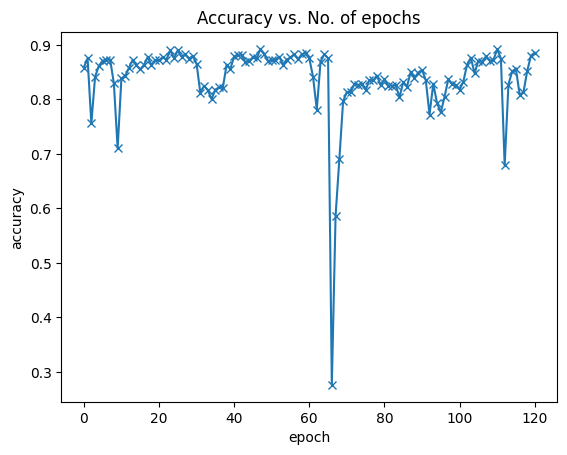

In [112]:
plot_accuracies(history)

In [113]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

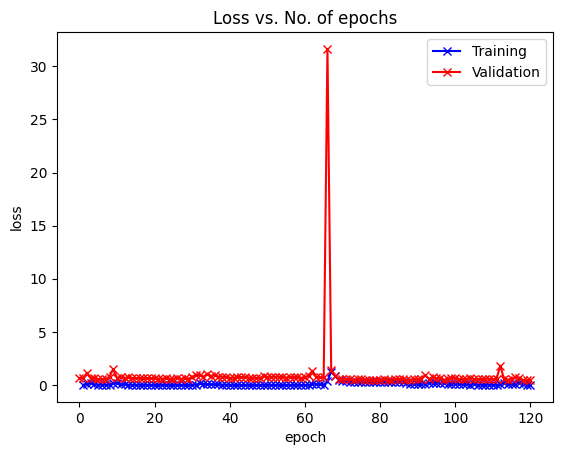

In [114]:
plot_losses(history)

### Record the Results

In [118]:
!pip install jovian --upgrade -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [119]:
import jovian

In [124]:
jovian.reset()
jovian.log_dataset(image_size = 64)
jovian.log_hyperparams(batch_size = 128,
                      arch='ResNet9',
                      epochs = [6,6], lrs=[0.001, 0.001],
                      weight_decay= [1e4, 1e3],
                      opt=['Adam', 'Adam'] )
jovian.log_metrics(train_loss= history[-1]['train_loss'],
                  val_acc=history[-1]['val_acc'],
                  val_loss=history[-1]['val_loss'])

[jovian] Dataset logged.
[jovian] Hyperparams logged.
[jovian] Metrics logged.


In [125]:
project_name = 'deep-learning-project-from-scratch'

In [126]:

jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


### Test with Individual Images

In [157]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [161]:
def show_image_prediction(img, label):
  plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
  pred = predict_image(img, model, dataset.classes)
  print('Target:', dataset.classes[label])
  print('Prediction:', pred)


Target: tulip
Prediction: tulip


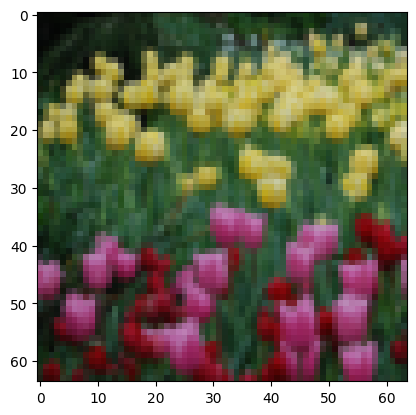

In [163]:
show_image_prediction(*valid_ds[3])


Target: dandelion
Prediction: dandelion


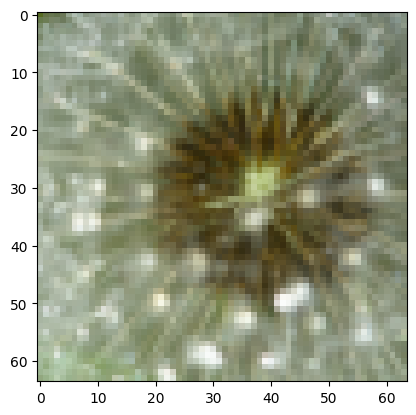

In [164]:
show_image_prediction(*valid_ds[69])

Target: tulip
Prediction: tulip


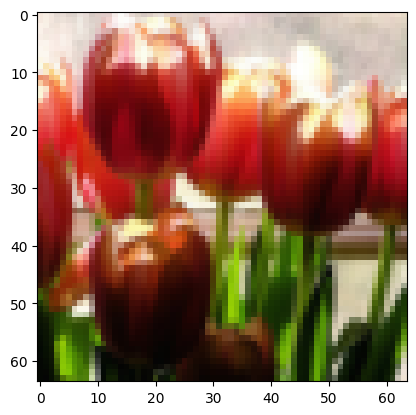

In [165]:
show_image_prediction(*valid_ds[108])

Target: rose
Prediction: rose


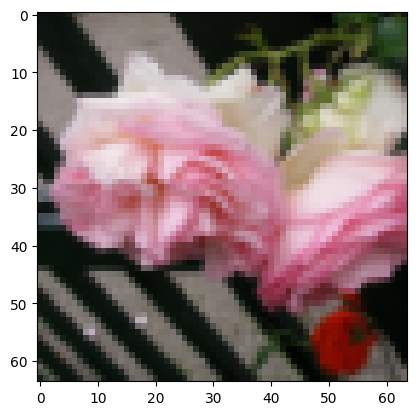

In [166]:
show_image_prediction(*valid_ds[369])

### Save and Commit

In [167]:
torch.save(model.state_dict(), 'Flowers-resnet9.pth')

In [168]:
jovian.commit(project_name, outputs=['Flowers-resnet9.pth'])

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


### Transfer Model

In [179]:
from torchvision import models

class ResNet34(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [180]:
model = to_device(ResNet34(len(dataset.classes), pretrained=True), device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [171]:
import torchvision.transforms as tt

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(img_size),
                                            tt.RandomCrop(img_size),
                                            tt.ToTensor(), tt.Normalize(*imagenet_stats)]))


In [173]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

batch_size = 64

# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=4, pin_memory=True)

In [174]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [176]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [196]:
model = to_device(ResNet34(len(dataset.classes), pretrained=True), device)

In [197]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.8956162929534912, 'val_acc': 0.2148556262254715}]

In [199]:
history += fit_one_cycle(10, 0.001, model, train_dl, valid_dl,
              weight_decay=0.01, grad_clip=0.1, opt_func=torch.optim.Adam)

  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.2069, val_loss: 0.6537, val_acc: 0.7979


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.4295, val_loss: 1.7556, val_acc: 0.4015


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.5651, val_loss: 1.0881, val_acc: 0.6620


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.5582, val_loss: 2.0931, val_acc: 0.6113


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.5799, val_loss: 0.6743, val_acc: 0.7734


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.4678, val_loss: 0.5900, val_acc: 0.8276


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.4011, val_loss: 0.4820, val_acc: 0.8359


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.3130, val_loss: 0.4140, val_acc: 0.8726


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.2095, val_loss: 0.4042, val_acc: 0.8748


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.1630, val_loss: 0.3554, val_acc: 0.8933


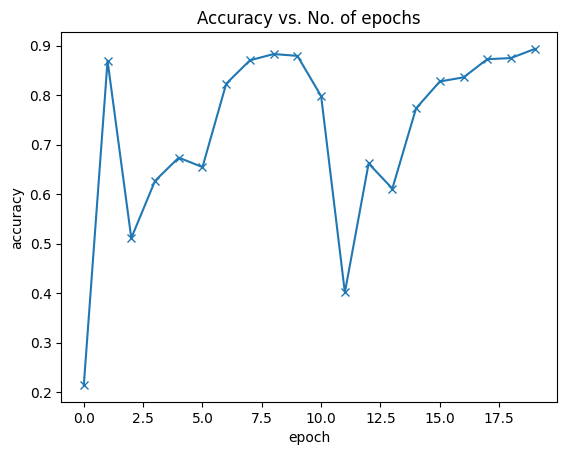

In [200]:
plot_accuracies(history)

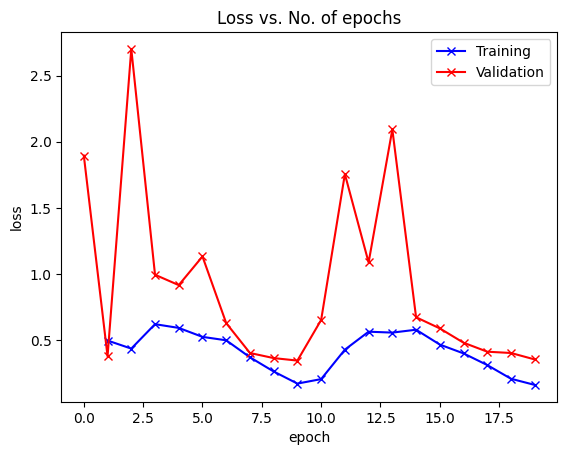

In [201]:
plot_losses(history)

Target: rose
Prediction: rose


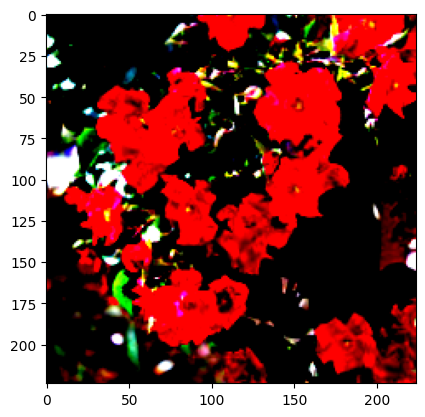

In [202]:
show_image_prediction(*valid_ds[3])

Target: rose
Prediction: rose


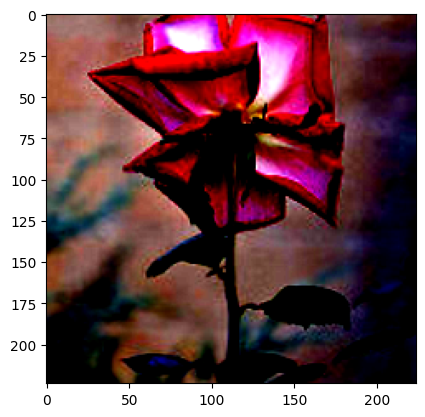

In [203]:
show_image_prediction(*valid_ds[69])

Target: tulip
Prediction: tulip


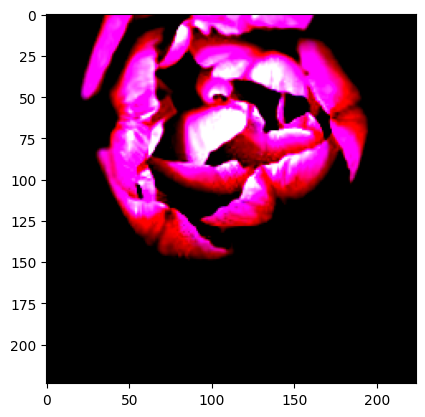

In [204]:
show_image_prediction(*valid_ds[108])

Target: sunflower
Prediction: sunflower


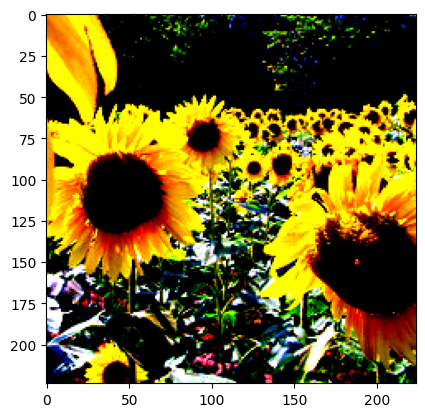

In [207]:
show_image_prediction(*valid_ds[369])